--- 1. Solution ALÉATOIRE (AVANT Recuit Simulé) ---
Makespan initial = 15


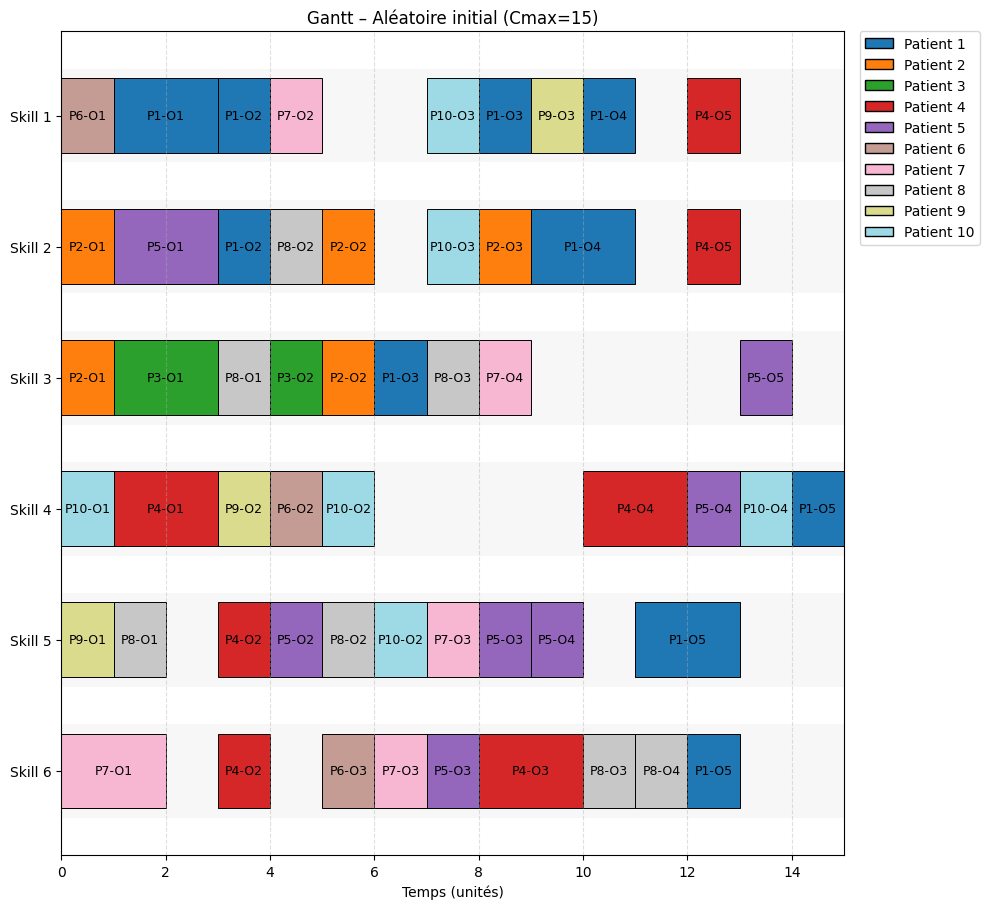


--- 2. Lancement du Recuit Simulé... ---
Makespan de départ optimisé pour SA: 12

--- 3. Solution OPTIMALE Recuit Simulé ---
Makespan après Recuit Simulé = 12


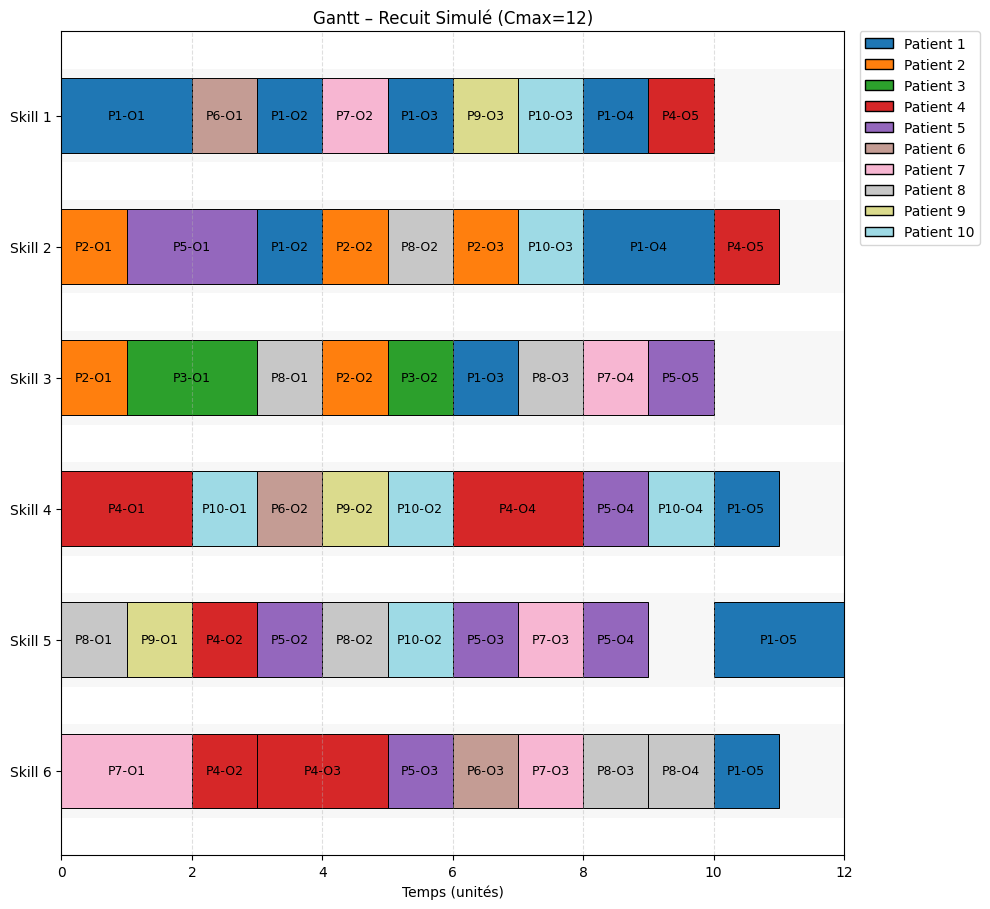

In [8]:
from copy import deepcopy
import random
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import math

# --- Global Constants ---
random.seed(random.randint(0, 100))

SKILLS = [1, 2, 3, 4, 5, 6]
NUM_PATIENTS = 10
MAX_OPS = 5  # au plus 5 opérations

DATA = {
    1: {
        1: [(1,2)],
        2: [(1,1),(2,1)],
        3: [(1,1),(3,1)],
        4: [(1,1),(2,2)],
        5: [(4,1),(5,2),(6,1)],
    },
    2: {
        1: [(2,1),(3,1)],
        2: [(2,1),(3,1)],
        3: [(2,1)],
        4: [],
        5: [],
    },
    3: {
        1: [(3,2)],
        2: [(3,1)],
        3: [],
        4: [],
        5: [],
    },
    4: {
        1: [(4,2)],
        2: [(5,1),(6,1)],
        3: [(6,2)],
        4: [(4,2)],
        5: [(1,1),(2,1)],
    },
    5: {
        1: [(2,2)],
        2: [(5,1)],
        3: [(5,1),(6,1)],
        4: [(4,1),(5,1)],
        5: [(3,1)],
    },
    6: {
        1: [(1,1)],
        2: [(4,1)],
        3: [(6,1)],
        4: [],
        5: [],
    },
    7: {
        1: [(6,2)],
        2: [(1,1)],
        3: [(5,1),(6,1)],
        4: [(3,1)],
        5: [],
    },
    8: {
        1: [(3,1),(5,1)],
        2: [(2,1),(5,1)],
        3: [(3,1),(6,1)],
        4: [(6,1)],
        5: [],
    },
    9: {
        1: [(5,1)],
        2: [(4,1)],
        3: [(1,1)],
        4: [],
        5: [],
    },
    10: {
        1: [(4,1)],
        2: [(4,1),(5,1)],
        3: [(1,1),(2,1)],
        4: [(4,1)],
        5: [],
    },
}

# ---------------------------
# 1) Data Structure and Task Creation
# ---------------------------
def create_task(num_patients, data, max_ops):
  """Crée toutes les tâches et les structures d'indexation."""
  Task = namedtuple("Task", ["i", "j", "s", "p"])
  ALL_TASKS = []
  TASKS_BY_SKILL_STAGE = defaultdict(list)
  PATIENT_LAST_STAGE = {i: 0 for i in range(1, num_patients + 1)}

  for i in range(1, num_patients + 1):
      if i in data:
          for j in range(1, max_ops + 1):
              ops = data[i].get(j, [])
              if ops:
                  PATIENT_LAST_STAGE[i] = j
              for (s, p) in ops:
                  t = Task(i=i, j=j, s=s, p=p)
                  ALL_TASKS.append(t)
                  TASKS_BY_SKILL_STAGE[(s, j)].append(t)

  return ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE

# Execute task creation
ALL_TASKS, TASKS_BY_SKILL_STAGE, PATIENT_LAST_STAGE = create_task(NUM_PATIENTS, DATA, MAX_OPS)

# ---------------------------
# 2) Initial Sequence Building (Random Order)
# ---------------------------
def build_initial_sequences(skills, max_ops, tasks_by_skill_stage):
    """
    Construit une séquence initiale de tâches (ordre ALÉATOIRE) pour chaque paire (s, j).
    """
    seq = {}
    for s in skills:
        for j in range(1, max_ops + 1):
            tasks = tasks_by_skill_stage.get((s, j), [])
            if not tasks:
                continue

            # Ordre ALÉATOIRE
            ordered_tasks = tasks[:]
            random.shuffle(ordered_tasks)

            seq[(s, j)] = ordered_tasks
    return seq

# ---------------------------
# 3) Règle de Correction (Contrainte J < J+1 & Contiguïté)
# ---------------------------
def correct_sequence_order(current_sequences, num_patients, max_ops, skills):
    """
    Règle de correction: L'ordre inter-opération (J < J+1) est géré par l'évaluateur.
    Ceci assure une séquence cohérente sur les ressources (s, j) en priorisant par Patient ID.
    Ceci est la même règle que l'ordre intra-étape Patient ID croissant.
    """
    corrected_sequences = {}

    for s in skills:
        for j in range(1, max_ops + 1):
            tasks = current_sequences.get((s, j), [])
            if not tasks:
                continue

            # Priorisation par Patient ID (i) croissant (ordre stable)
            ordered_tasks = sorted(tasks, key=lambda t: t.i)

            corrected_sequences[(s, j)] = ordered_tasks

    return corrected_sequences


# --------------------------
# 4) Voisinage pour le Recuit Simulé (Swap and Insert)
# --------------------------
def get_neighbor_swap(sequences, skills, max_ops):
    """
    Génère une solution voisine en échangeant deux tâches adjacentes
    dans une séquence (s, j) choisie aléatoirement.
    """
    new_sequences = deepcopy(sequences)

    valid_keys = [k for k, v in sequences.items() if len(v) >= 2]
    if not valid_keys:
        return None # Impossible de générer un voisin

    s, j = random.choice(valid_keys)
    sequence = new_sequences[(s, j)]

    idx = random.randint(0, len(sequence) - 2)
    sequence[idx], sequence[idx+1] = sequence[idx+1], sequence[idx]

    return new_sequences

def get_neighbor_insert(sequences, skills, max_ops):
    """
    Génère oune solution voisine en insérant une tâche d'une position à une autre
    dans une séquence (s, j) choisie aléatoirement.
    """
    new_sequences = deepcopy(sequences)

    valid_keys = [k for k, v in sequences.items() if len(v) >= 2]
    if not valid_keys:
        return None # Impossible de générer un voisin

    s, j = random.choice(valid_keys)
    sequence = new_sequences[(s, j)]

    idx1 = random.randint(0, len(sequence) - 1)
    idx2 = random.randint(0, len(sequence) - 1)

    if idx1 == idx2:
        return new_sequences # No change

    task_to_move = sequence.pop(idx1)
    sequence.insert(idx2, task_to_move)

    return new_sequences


# --------------------------
# 5) Algorithme de Recuit Simulé
# --------------------------
def simulated_annealing(initial_sequences, skills, num_patients, data, patient_last_stage, max_ops,
                        T0=10.0, alpha=0.99, max_iter=5000):
    """
    Implémente le Recuit Simulé pour minimiser le Makespan en utilisant
    soit un swap soit une insertion pour générer des voisins.
    """

    # Initialisation
    current_sequences = initial_sequences
    current_cost = evaluate_schedule(current_sequences, skills, num_patients, data, patient_last_stage, max_ops)

    best_sequences = deepcopy(current_sequences)
    best_cost = current_cost
    T = T0

    # Historique pour le suivi (optionnel)
    history = [current_cost]

    for iteration in range(max_iter):

        # 1. Générer un voisin (randomly choose between swap and insert)
        if random.random() < 0.5: # 50% chance of swap
            neighbor_sequences = get_neighbor_swap(current_sequences, skills, max_ops)
        else: # 50% chance of insert
             neighbor_sequences = get_neighbor_insert(current_sequences, skills, max_ops)


        if neighbor_sequences is None:
            break

        # 2. Calculer le coût du voisin
        neighbor_cost = evaluate_schedule(neighbor_sequences, skills, num_patients, data, patient_last_stage, max_ops)

        delta_E = neighbor_cost - current_cost

        # 3. Décision d'acceptation
        if delta_E < 0:
            # Meilleur que le courant : accepter
            current_sequences = neighbor_sequences
            current_cost = neighbor_cost

            # Mettre à jour la meilleure solution globale
            if current_cost < best_cost:
                best_cost = current_cost
                best_sequences = deepcopy(current_sequences)

        elif T > 0 and random.random() < math.exp(-delta_E / T):
            # Moins bon, mais accepter avec une probabilité
            current_sequences = neighbor_sequences
            current_cost = neighbor_cost

        # 4. Refroidissement
        T *= alpha

        history.append(current_cost)

        if iteration % 500 == 0:
            # print(f"Iter {iteration}, T={T:.2f}, Current Cmax={current_cost}, Best Cmax={best_cost}")
            pass

        # Condition d'arrêt si la température est trop basse ou le nombre d'itérations atteint
        if T < 0.01:
            break

    return best_sequences, best_cost, history

# --------------------------
# 6) Evaluation (construction du planning "par étapes")
# --------------------------
def evaluate_schedule(sequences, skills, num_patients, data, patient_last_stage, max_ops, return_schedule=False):
    """
    sequences: dict (s,j) -> liste ordonnée de Task
    Calcule un planning non préemptif en respectant l'ordre des opérations (par étapes j=1..max_ops).
    """

    # disponibilité des ressources (temps où la ressource s sera libre)
    res_free = {s: 0 for s in skills}
    # fin de l'étape j pour chaque patient, initialisé à 0 pour l'étape 0
    op_completion = { (i, 0): 0 for i in range(1, num_patients + 1) }
    # pour stocker les dates de chaque tâche
    task_times = {}

    for j in range(1, max_ops + 1):
        stage_finish = defaultdict(int)

        for s in skills:
            tasks = sequences.get((s, j), [])
            for t in tasks:
                # ready: La tâche ne peut commencer qu'après la fin de l'étape précédente (J-1) du patient.
                ready = op_completion[(t.i, j - 1)]

                # start: La tâche commence au plus tard entre la disponibilité de la ressource et la disponibilité du patient.
                start = max(res_free[s], ready)
                finish = start + t.p

                res_free[s] = finish
                stage_finish[t.i] = max(stage_finish[t.i], finish)
                task_times[(t.i, j, s)] = (start, finish, t.p)

        # Figer la fin de l'étape j pour tous les patients
        for i in range(1, num_patients + 1):
            if data[i].get(j, []):
                op_completion[(i, j)] = stage_finish[i]
            else:
                op_completion[(i, j)] = op_completion[(i, j - 1)]


    # makespan = max fin de dernière étape existante par patient
    makespan = 0
    for i in range(1, num_patients + 1):
        last_j = patient_last_stage[i]
        makespan = max(makespan, op_completion[(i, last_j)])

    if return_schedule:
        return makespan, task_times, op_completion

    return makespan

# --------------------------
# 7) Visualisation du Gantt (fonctions inchangées)
# --------------------------
def _patient_colors(num_patients):
    """Palette stable pour n patients (tab20)."""
    cmap = plt.colormaps.get_cmap("tab20")
    n = min(20, num_patients)
    return {i+1: cmap(i / (n-1)) if n>1 else cmap(0) for i in range(num_patients)}

def build_gantt_data(task_times, skills):
    """
    Re-formate task_times -> dict skill -> liste d'items triés
    """
    by_skill = {s: [] for s in skills}
    horizon = 0
    for (i, j, s), (start, finish, p) in task_times.items():
        by_skill[s].append({
            "start": start, "end": finish, "dur": p,
            "patient": i, "op": j
        })
        horizon = max(horizon, finish)

    for s in skills:
        by_skill[s].sort(key=lambda x: (x["start"], x["patient"], x["op"]))

    return by_skill, horizon

def plot_gantt(task_times, skills, num_patients, title="Gantt – Planning par compétence",
               figsize=None, annotate=True, save_path=None, dpi=150):
    """Génère et affiche le diagramme de Gantt."""
    by_skill, horizon = build_gantt_data(task_times, skills)

    if horizon == 0:
        print("Makespan is 0. Cannot plot Gantt chart.")
        return

    colors = _patient_colors(num_patients)

    if figsize is None:
        figsize = (max(10, horizon * 0.4), 1.2 * len(skills) + 2)

    fig, ax = plt.subplots(figsize=figsize)

    lane_height = 0.8
    y_gap = 0.6
    y_positions = {s: (len(skills)-idx-1)*(lane_height + y_gap) for idx, s in enumerate(skills)}
    ymin = -0.5
    ymax = max(y_positions.values()) + lane_height + 0.5

    for s in skills:
        y = y_positions[s]
        ax.add_patch(Rectangle((0, y - 0.1), horizon, lane_height + 0.2,
                               facecolor=(0,0,0,0.03), edgecolor="none"))
        for it in by_skill[s]:
            start = it["start"]
            dur   = it["dur"]
            i     = it["patient"]
            j     = it["op"]
            rect = Rectangle((start, y), dur, lane_height,
                             facecolor=colors[i], edgecolor="black", linewidth=0.7)
            ax.add_patch(rect)
            if annotate:
                label = f"P{i}-O{j}"
                ax.text(start + dur/2, y + lane_height/2, label,
                        ha="center", va="center", fontsize=9)

    ax.set_xlim(0, math.ceil(horizon))
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Temps (unités)")
    ax.set_yticks([y_positions[s] + lane_height/2 for s in skills])
    ax.set_yticklabels([f"Skill {s}" for s in skills])
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    legend_handles = [Patch(facecolor=colors[i], edgecolor="black", label=f"Patient {i}") for i in range(1, num_patients + 1)]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Gantt sauvegardé : {save_path}")
    plt.show()

# --------------------------
# 8) Main Execution: Random Start -> SA -> Evaluation
# --------------------------

# --- 1. Solution initiale ALÉATOIRE (sans correction) ---
# La correction sera appliquée par le SA sur la meilleure solution trouvée
initial_random_seq = build_initial_sequences(SKILLS, MAX_OPS, TASKS_BY_SKILL_STAGE)

mk_initial, task_times_initial, _ = evaluate_schedule(
    sequences=initial_random_seq,
    skills=SKILLS,
    num_patients=NUM_PATIENTS,
    data=DATA,
    patient_last_stage=PATIENT_LAST_STAGE,
    max_ops=MAX_OPS,
    return_schedule=True
)

print(f"--- 1. Solution ALÉATOIRE (AVANT Recuit Simulé) ---")
print(f"Makespan initial = {mk_initial}")
plot_gantt(task_times_initial, SKILLS, NUM_PATIENTS, title=f"Gantt – Aléatoire initial (Cmax={mk_initial})")

# --- 2. Lancement du Recuit Simulé ---
print("\n--- 2. Lancement du Recuit Simulé... ---")
# Utilisation de la séquence corrigée par Patient ID comme point de départ pour une exploration plus efficace
# Note: On utilise `correct_sequence_order` pour avoir un point de départ plus "sensé"
sa_start_seq = correct_sequence_order(initial_random_seq, NUM_PATIENTS, MAX_OPS, SKILLS)
sa_start_cost = evaluate_schedule(sa_start_seq, SKILLS, NUM_PATIENTS, DATA, PATIENT_LAST_STAGE, MAX_OPS)
print(f"Makespan de départ optimisé pour SA: {sa_start_cost}")


best_sequences_sa, mk_best_sa, history = simulated_annealing(
    initial_sequences=sa_start_seq,
    skills=SKILLS,
    num_patients=NUM_PATIENTS,
    data=DATA,
    patient_last_stage=PATIENT_LAST_STAGE,
    max_ops=MAX_OPS,
    T0=10.0, alpha=0.999, max_iter=20000
)


# --- 3. Évaluation de la solution optimale Recuit Simulé ---
mk_best_sa, task_times_best_sa, _ = evaluate_schedule(
    sequences=best_sequences_sa,
    skills=SKILLS,
    num_patients=NUM_PATIENTS,
    data=DATA,
    patient_last_stage=PATIENT_LAST_STAGE,
    max_ops=MAX_OPS,
    return_schedule=True
)

print(f"\n--- 3. Solution OPTIMALE Recuit Simulé ---")
print(f"Makespan après Recuit Simulé = {mk_best_sa}")
plot_gantt(task_times_best_sa, SKILLS, NUM_PATIENTS, title=f"Gantt – Recuit Simulé (Cmax={mk_best_sa})")